# t-SNE Visualization

Many thanks to https://github.com/spmallick/learnopencv/tree/master/TSNE.

In [ ]:
from dataset import TrainSet
from torch.utils.data import DataLoader
import torch
from constant import *
import argparse
from resnet101 import Classifier
from utils import get_device
import numpy as np
import glob
from sklearn.manifold import TSNE
from tqdm import tqdm

In [2]:
import torch.nn as nn
from torchvision import models

model_name = 'resnet101'

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.name = 'resnet101'
        self.model = nn.Sequential(
            *list(getattr(models, self.name)(pretrained = True).children())[:-1]
        )
        
    def forward(self, x):
        x = self.model(x)
        return x 

In [3]:
test_set = TrainSet(path = '/tmp2/b08902134/testdata/hw1_data/p1_data/val_50', transform = test_tfm)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)

In [4]:
device = get_device()
model = Classifier().to(device)
model.eval()

Classifier(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64,

In [5]:
output_name, raw_prediction, output = [], [], []


features = []
labels = []

for batch in tqdm(test_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model(imgs.to(device))
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
    # features = logits if features is None else np.concatenate((features, logits))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.68it/s]


In [6]:
colors_per_class = [list(np.random.choice(range(256), size=3)) for i in range(50)]

In [7]:
print(labels[0], features[0])

0 [0.48322603 0.0833685  0.8644196  ... 0.4768603  0.05843714 0.02929962]


In [8]:
tsne = TSNE(n_components=2, init = 'pca').fit_transform(features)

/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [18]:
import matplotlib.pyplot as plt

def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)

    return starts_from_zero / value_range

def visualize_tsne_points(tx, ty, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for label in range(50):
        indices = [i for i, l in enumerate(labels) if l == label]

        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)

        color = np.array([colors_per_class[label][::-1]], dtype=np.float) / 255

        ax.scatter(current_tx, current_ty, c=color, label=label)
    ax.legend(loc='best')

    plt.show()


In [10]:
def visualize_tsne(tsne, labels, plot_size=1000, max_image_size=100):
    tx = tsne[:, 0]
    ty = tsne[:, 1]
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)
    visualize_tsne_points(tx, ty, labels)

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

/tmp2/b08902134/ipykernel_2813898/879795142.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  color = np.array([colors_per_class[label][::-1]], dtype=np.float) / 255


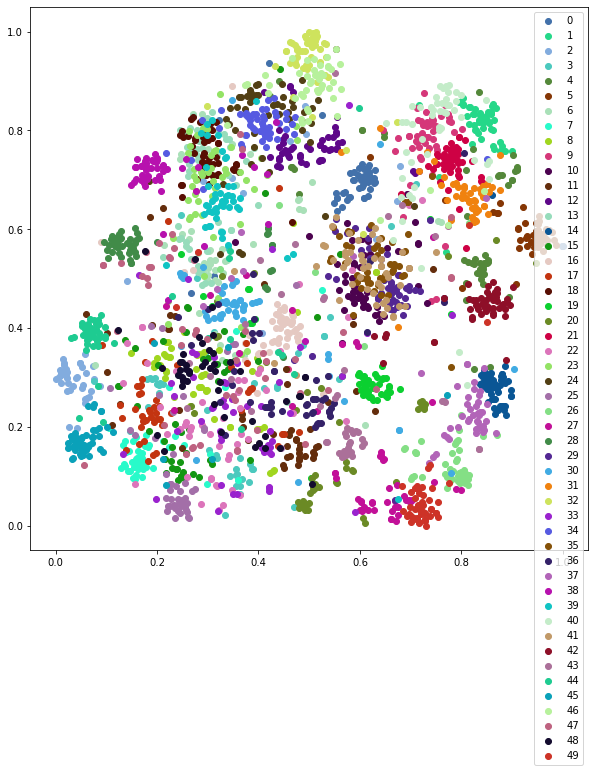

In [19]:
visualize_tsne(tsne, labels)